## 0. 사용할 라이브러리 불러오기

In [234]:
!pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


 summa가 깔려있지 않으니 새로 인스톨해줍니다.

In [235]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords #상기 3개의 nltk는 불용어처리용
import tensorflow as tf
import summa
import requests
from summa.summarizer import summarize
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import urllib.request
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. 데이터 불러오기

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

github url을 통해 바로 data 다운로드 없이 온라인상으로 저장했습니다. 

In [ ]:
data.sample(10)

,headlines,text
37889,Man takes Ã¢ÂÂ¹15-lakh loan to screen World C...,A football fan in Assam took a bank loan of Ã¢...
46891,"2,000-year-old Roman 'boxing gloves' dug out i...","UK-based researchers have uncovered Roman ""box..."
31235,I hope I don't trip and fall on red carpet at ...,"Pakistani actress Mahira Khan, who will make h..."
74223,Neymar dribbles past 5 defenders to score goal,"World's most expensive footballer Neymar, maki..."
74426,"No nepotism as RK Studios isn't launching me, ...",Aadar Jain has said he is not a product of nep...
35882,"Court rules farting isn't bullying, dismisses ...",A construction firm employee has lost a $1.8 m...
38527,Bhaiyyuji Maharaj leaves all property to his s...,The police have recovered the second page of s...
75785,Delhi institute rolls back 'biased' hostel tim...,Delhi Technological University has tentatively...
13787,Buffalo meat wrongly printed as beef in Mumbai...,An advertisement by the Brihanmumbai Municipal...
39095,2 men lynched after being mistaken as kidnappe...,Two men were lynched in Assam's Karbi Anglong ...


앞서 아마존 리뷰처럼 text 부분과 summary(headline)부분 으로 나눠져 있으니, 인코더/디코더로 나눠서 진행하면 될 것 같습니다!  
총 몇 개가 있는지 확인해볼까요

In [ ]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [ ]:
print(data['text'])
print(data['headlines'])

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object
0        upGrad learner switches to career in ML & Al w...
1        Delhi techie wins free food from Swiggy for on...
2        New Zealand end Rohit Sharma-led India's 12-ma...
3        Aegon life iTerm insurance plan helps customer...
4        Have known Hirani for yrs, what if MeToo claim...
               

각 열로 잘 나눠져 있고, 갯수는 98,401개로 약 10만개정도 있으니 데이터 삭제없이 전처리를 진행하도록 합니다.  

## 2. 데이터 전처리(추상적 요약)

### 1) 중복 샘플 및 Null 값 제거  

먼저 혹시 모를 중복 및 null 값을 제거해주도록 합니다.

In [ ]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [ ]:
hedlines_overlap = data[data['headlines'].duplicated()]
print(hedlines_overlap['headlines'])

3292     Isha Ambani features on February cover of Vogu...
3293     Indian Oil looking for annual deal to buy crud...
32850    David Beckham once scored a 60-yard goal from ...
34227    Sachin once fielded for Pakistan before making...
34518      Iraq launches air strikes against ISIS in Syria
                               ...                        
95135    Parveen Babi was 1st Indian film star on TIME ...
95473    Sachin had not let Sehwag watch 2011 World Cup...
95670    How did the tradition of April Fools' Day orig...
96540    Sachin first opened in ODIs due to Sidhu's 'st...
97489              Who are the richest women in the world?
Name: headlines, Length: 121, dtype: object


역시 기존 98,401개와 다른 숫자를 출력하고 있습니다.  
왜 text와 headlines의 중복제외 숫자가 다른지는 의문입니다...만....  
headlines 중복 데이터 121개를 실제 데이터에서 찾아보니, headlines가 겹치면 text도 중복이라는 것을 확인했습니다. 그럼 먼저 headlines의 중복데이터를 `drop_duplicates()`로 지우고 다시 text의 중복데이터를 확인해봅니다.  

In [ ]:
data.drop_duplicates(subset = ['headlines'], inplace=True)

In [ ]:
print('전체 샘플수 :', (len(data)))
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

전체 샘플수 : 98280
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98262
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


text가 같은데 headlines가 다르다...?  
이걸 중복으로 봐야할까...? 같은 문장에서 다른 서머리를 뽑아낼 수도 있는거 아닐까?  

한번 실제 데이터를 확인해보자.

In [ ]:
text_overlap = data[data['text'].duplicated()]
print(text_overlap['text'])

20754    Safeguard yourself against life's unpleasant s...
44594    Berger Paints has launched Berger Express Pain...
52021    Australia's Anthony Stuart took a hat-trick in...
53578    Former Windies' captain Brian Lara named his f...
53865    Cricket legend Don Bradman reversed the Austra...
53892    German Formula One legend Michael Schumacher, ...
54078    Former Australian leg-spinner Shane Warne was ...
55208    During an El ClÃÂ¡sico match in 2002, Barcelo...
57402    Virender Sehwag was captaining India when he h...
58715    The first-ever official international football...
58934    Windies' Gus Logie was adjudged Man of the Mat...
61055    The first wicket and first catch in Test crick...
61445    Former Australian fast bowler Glenn McGrath, w...
62639    Former batsman Sachin Tendulkar became the fir...
62785    India conceded an ODI against Pakistan on Nove...
78519    A TechCrunch report has claimed that IndiaÃ¢Â...
80355    As many as 54,250 fluorescent-yellow tennis ba.

"Berger Express Painting introduces fast and dust-free home painting"  
"Berger introduces T20 of painting with Express Painting"
등 **같은 내용이지만 summary를 다르게 한 데이터**들을 보니, 이것도 좋은 소스가 되지 않을까 싶다.  
(오히려 더 헷갈리려나..?)  

---

이런걸 **이상치**라고함. 과적합을 줄이기 위해서 이런 노이즈를 일부러 줄 수도있지만, 학습단계에서는 거의 안한다고 한다.  
그럼 지워야겠다...^_^..... 지워주자!

In [ ]:
data.drop_duplicates(subset = ['text'], inplace=True)

In [ ]:
print('전체 샘플수 :', (len(data)))
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

전체 샘플수 : 98262
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98262
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98262


샘플수와 text, headlines의 수가 같아져 중복값이 없는 것을 확인할 수 있다.  

그리고 있을지 모른 null값을 확인하고 제거해주자.

In [ ]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

중복값, null값 모두 없는 것을 확인했다.  
이제 텍스트 정규화 및 불용어를 제거해주자.

### 텍스트 정규화 & 불용어 제거  

데이터가 영문이니 I'll -> I will 처럼 영문에 맞는 정규화 처리를 해주자.  
(이전 실습 데이터 처리에서 이 방법을 알았으면 더 정확한 학습을 하고 데이터를 뽑아낼 수 있지 않을까 아쉬움이 남는다.)

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "yrs": "years"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  121


정규화 준비를 마쳤으니, NLTK의 stopwors를 사용하여 불용어 처리를 해주자.

In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

정규화 및 불용어 처리준비를 마쳤다.  
그리고 이 외에 소문자화, html 태그 제거 등을 전처리 함수를 사용해 적용해주자.  

이번 데이터는 뉴스 텍스트 및 헤드라인으로 리뷰처럼 ummmm 같은 일상어는 나올일이 없으니 관련된 re.sub는 제외하고 적용해주자. 

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('전처리 함수 준비끝:)')

전처리 함수 준비끝:)


아까 랜덤으로 확인한 데이터에서 â¹ 같이 이상한 내용이 있었는데, 이걸 포함해서 잘 처리되는지 한번 확인해본다.

In [ ]:
temp_text = "it's i'll could save $5 billion (nearly â¹33,500 crore) over next seven yrs,"

print("text: ", preprocess_sentence(temp_text))

text:  could save billion next seven yrs


옥키! 잘 제거되는 것을 확인했다. 역시 능력이 좋구만.  

함수가 잘 처리하는것을 보았으니, 훈련데이터 전체에 대해 전처리를 수행하자.  
이때, text는 불용어를 제거하고, Headlines의 경우는 불용어를 제거하지 않을 것이니 따로 호출해서 진행하도록 하자. 

In [ ]:
clean_text = []
# 전체 Text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

이제 headlines에 대해서 전처리 함수를 처리할 땐, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어주자

In [ ]:
clean_headlines = []
# 전체 Headlines 데이터에 대한 전처리
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("Headlines 전처리 후 결과: ", clean_headlines[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


전처리한 clean_~ 데이터들을 원래 text와 headlines로 넣어주자.  

그리고 전처리 후 혹시라도 빈값을 가진 샘플이 있을 수 있으니 null값으로 처리해 지워주자

In [ ]:
data['Text'] = clean_text
data['Headlines'] = clean_headlines
#이후 모델학습을 위해 중간 저장해준다

In [ ]:
data['text'] = data['Text']
data['headlines'] = data['Headlines']

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('null 처리 완료:)')

null 처리 완료:)


In [ ]:
#null 갯수 확인
data.isnull().sum()

headlines    0
text         0
Text         0
Headlines    0
dtype: int64

### 2) Train/Test 데이터 나눠주기

---

학습에 사용할 데이터 크기를 결정해주고, 문장의 시작과 끝을 표시해주자.

#### 샘플의 최대 길이 정하기
- 샘플들이 최소/최대/평균 길이 및 분포를 확인한다

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299444342675704


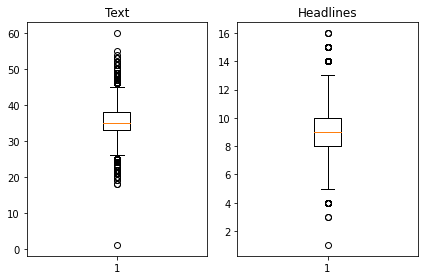

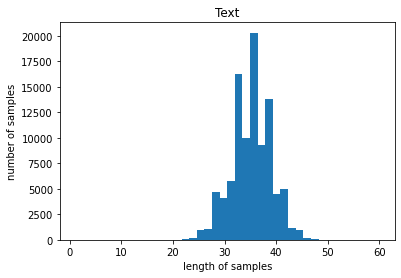

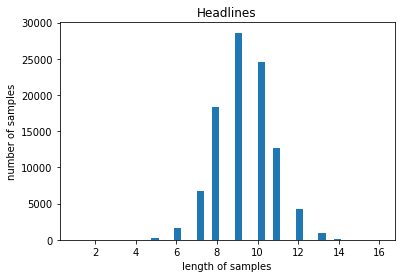

In [ ]:
# 길이 분포 출력


text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Text의 경우
- 최소 길이: 1
- 최대 길이: 60
- 평균 길이: 35  
시각화된 그래프로 봤을 때, 대체적으로 30~40내외의 길이를 가진다는 것을 확인할 수 있다.

Headlines의 경우
- 최소 길이: 1
- 최대 길이: 16
- 평균 길이: 9  
시각화된 그래프로 봤을 때, 대체적으로 8~10 내외의 길이를 가지고 있다는 것을 알 수 있다.

또한 Headlines의 경우 평균길이가 9로 text 원문이 35인것에 비해 약 4배정도 차이가 나는 것을 알 수 있다. 

흠... 저 text에서 길이 1짜리가 튀어서 뭔지 확인해보고 싶다..!  

In [ ]:
curious_data = [idx for idx, val in enumerate(text_len) if val <= 5 ]
print(curious_data)

[52]


In [ ]:
data.loc[52] 

headlines    headlines
text              text
Text              text
Headlines    headlines
Name: 52, dtype: object

뭐야... headlines은 headlines이고, text는 text다....   
기자가 일하기 싫었나...?ㅋㅋㅋ 이 값도 잊지않고 제거해주도록 하고, 

이제 어느정도 길이를 정해야 샘플을 많이 자르지 않고 담을 수 있는지 확인해보자. 

우선 임의로 text의 max_len은 50, headlines의 max_len은 14로 정해본다.

In [ ]:
#52번 데이터 삭제
data=data.drop([52],axis=0)

In [ ]:
text_max_len = 50
headlines_max_len = 14
print('max_len 설정 완료')

max_len 설정 완료


In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('max_len별 샘플 비율 함수 설정 완료:)')

max_len별 샘플 비율 함수 설정 완료:)


In [ ]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998575223130235
전체 샘플 중 길이가 14 이하인 샘플의 비율: 0.9997761064918941


각각 max_len 보다 큰 샘플 비율이 약 1%정도다.  
더 잘라내보고 싶지만, 쫄보는 데이터 하나하나가 소중하기때문에... 이대로 진행해본다.

---

@NLP에서 데이터 처리시 n% 이상은 이상비율로 처리해서 자른다는게 논문이나 자료로 나와있으면 그것에 맞춰서 자르고 싶은데,, 나와있지 않으니 결정하기 어렵다.  
정규분포로 따져서 뭐 5%로 자른다 하기엔 정규분포를 따르는게 아니니까...  
그래도 어느정도 boxplot에서 크게 벗어난 데이터는 삭제했다는 생각으로 계속 진행해보기로했다.

In [ ]:
data['Text'] = data['text']
data['Headlines'] = data['headlines']
#짜르기 전에 이후 모델학습을 위해 중간 저장해준다

In [ ]:
data['text'] = data['Text']
data['headlines'] = data['Headlines']

In [ ]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98225


전체 샘플수 : 98262 -> 98225로 (52번 데이터 포함) 약 37개가 삭제 되었다. 

#### 시작 토큰과 종료 토큰 추가하기

In [ ]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,Text,Headlines,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


decord의 headlines의 앞에 sostoken이 붙은 input과 뒤에 eostoken이 붙은 target이 생긴것을 확인했다. 이 값들을 다시 NUMPY 타입으로 저장해주자.

---

아.... years의 줄임말인 yrs가 눈에 띈다.... 누네띠네... 요약문에 큰 영향을 주진 않을 것 같아 그냥 넘어가기로한다....     
(아니 한번 처리했는데도 안없어지네...?)  
어떻게하면 미리 저런 데이터를 처리해서 시간단축을 시킬 수 있을까?  


In [ ]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('인코더/디코더 레이블 입력 완료:)')

인코더/디코더 레이블 입력 완료:)


이제 trainning/validation 데이터를 나누자.   
sklearn을 사용해서 분리해보고 싶었는데, 나눠야할 게 3가지가 되니 조금 머리가 아파 그냥 mix 정수 시퀀스를 만들어서 나눠주자.


In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[76690 83427 37058 ... 71260 96730   305]


In [ ]:
encoder_input_save = encoder_input[indices]
decoder_input_save = decoder_input[indices]
decoder_target_save = decoder_target[indices]
#중간저장용 save 

In [ ]:
encoder_input = encoder_input_save
decoder_input = decoder_input_save
decoder_target = decoder_target_save
print('random 샘플 정의 완료:)')

random 샘플 정의 완료:)


이제 섞인 데이터를 8:2의 비율로 train, test로 나눠준다

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19645


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78580
훈련 레이블의 개수 : 78580
테스트 데이터의 개수 : 19645
테스트 레이블의 개수 : 19645


encorder/decorder의 input/target 데이터가 잘 나눠진 것을 볼 수 있다. 

이제 vocab 생성 및 정수 인코딩을 진행하자. 

### 3) 정수 인코딩

#### 단어 집합(vocabulary) 만들기 및 정수 인코딩
---
이제 encorder/decorder의 input/target으로 나눠진 묶음에 대해 vocab을 생성하자 

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('enc_input_train 토크나이저 끝:)')

enc_input_train 토크나이저 끝:)


In [ ]:
#토크나이저 잘됐는지 확인
for idx in src_tokenizer.index_word:
    print(idx, ":", src_tokenizer.index_word[idx])

    if idx >= 10: break

1 : said
2 : india
3 : year
4 : added
5 : us
6 : also
7 : first
8 : government
9 : police
10 : people


2위가 india요...? 기자가 인도사람이라 인도 얘기가 주를 이루나보다

여기서 빈도수가 낮은 단어들은 훈련데이터에서 제외해 속도 및 정확도를 올려주자

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69637
등장 빈도가 6번 이하인 희귀 단어의 수: 47401
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22236
단어 집합에서 희귀 단어의 비율: 68.06869911110472
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.476413006478443


약 7만개의 단어 중 47,000여개의 단어(전체 중 68%)가 4%내의 빈도로 등장하여, 상대적으로 적은 빈도의 단어들이 큰 수를 차지하고 있는 것을 알 수 있다.  
따라서 등장 빈도가 7 이하인 단어를 제거해서 vocab의 수를 약 22,000으로 설정하겠습니다.  
(지난 실습을 진행해보니 vocab의 수를 무조건 크게 잡는게 좋은게 아니라는 것을 알았다...!)

In [ ]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('vocab 재설정 완료:)')

vocab 재설정 완료:)


In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[5090, 6704, 4078, 568, 895, 3582, 1949, 7244, 100, 3169, 20690, 1583, 4078, 25, 8388, 350, 163, 5145, 2761, 1569, 4590, 724, 10276, 4078, 568, 5880, 19399, 17403, 20691, 22, 4078, 568], [1492, 343, 1375, 298, 2429, 4768, 1013, 1060, 846, 784, 2411, 1652, 62, 1003, 986, 2853, 5333, 882, 188, 11, 2910, 1003, 159, 193, 1973, 3063, 202], [262, 440, 1839, 2775, 381, 795, 197, 66, 2729, 1300, 530, 658, 384, 2, 66, 1102, 941, 1023, 2043, 5487, 436, 530, 2354, 485, 1164, 1839, 1959, 2, 530, 69, 6, 612, 295, 6243, 658]]


이제 encoder의 input 데이터들이 22,000 이하의 정수들로 바뀐것을 확인할 수 있다.   
headlines의 데이터도 처리해주자

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('Summary 단어집 생성완료:)')

Summary 단어집 생성완료:)


In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30221
등장 빈도가 5번 이하인 희귀 단어의 수: 19794
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10427
단어 집합에서 희귀 단어의 비율: 65.49750173720261
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.652065407772643


headlines의 경우 5번 이하의 희귀단어가 약 19,000로 65%의 크기를 차지하는 반면, 등장은 5% 내 밖에 되지 않는 것을 알 수 있다.  

따라서 단어집의 크기를 깔끔하게 10,000개로 잡아주자

In [ ]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:10])
print('target')
print('target ',decoder_target_train[:10])

input
input  [[1, 3, 5196, 241, 2529, 3, 21, 4831, 14, 18, 349], [1, 2804, 1564, 4, 529, 404, 3, 1812, 48, 3], [1, 1147, 107, 2917, 719, 215, 2579, 14, 8, 433], [1, 3694, 3, 115, 16, 1406, 7709, 13], [1, 23, 477, 3, 2160, 361, 5017, 12, 1761, 2016], [1, 1455, 3902, 3, 559, 661, 1077, 169, 1519, 13, 106, 28], [1, 398, 1520, 1098, 5891, 90, 31, 1577, 5, 38], [1, 778, 44, 4, 13, 3, 736, 2855, 4, 2737], [1, 322, 500, 2856, 460, 3, 501, 11, 147], [1, 1565, 759, 333, 35, 15, 136, 7, 1245, 307, 4, 13]]
target
target  [[3, 5196, 241, 2529, 3, 21, 4831, 14, 18, 349, 2], [2804, 1564, 4, 529, 404, 3, 1812, 48, 3, 2], [1147, 107, 2917, 719, 215, 2579, 14, 8, 433, 2], [3694, 3, 115, 16, 1406, 7709, 13, 2], [23, 477, 3, 2160, 361, 5017, 12, 1761, 2016, 2], [1455, 3902, 3, 559, 661, 1077, 169, 1519, 13, 106, 28, 2], [398, 1520, 1098, 5891, 90, 31, 1577, 5, 38, 2], [778, 44, 4, 13, 3, 736, 2855, 4, 2737, 2], [322, 500, 2856, 460, 3, 501, 11, 147, 2], [1565, 759, 333, 35, 15, 136, 7, 1245, 307, 4, 13, 

이렇게 삭제하고 나면, 데이터 내에서 빈도수가 낮은 단어들만으로 구성된 샘플들은 빈값으로 남아있을 가능성이 있다.  
혹시 모를 가능성을 없애기위해 빈 데이터들을 찾아 삭제해주자

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train_save = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train_save = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train_save = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test_save = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test_save = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test_save = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train_save))
print('훈련 레이블의 개수 :', len(decoder_input_train_save))
print('테스트 데이터의 개수 :', len(encoder_input_test_save))
print('테스트 레이블의 개수 :', len(decoder_input_test_save))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78580
훈련 레이블의 개수 : 78580
테스트 데이터의 개수 : 19645
테스트 레이블의 개수 : 19645


#### 중간저장 POINT★

In [ ]:
encoder_input_train = encoder_input_train_save
decoder_input_train = decoder_input_train_save
decoder_target_train = decoder_target_train_save
encoder_input_test = encoder_input_test_save
decoder_input_test = decoder_input_test_save
decoder_target_test = decoder_target_test_save
#여기도 중간저장

뉴스와 헤드라인이라 그런지 빈도수가 낮은 데이터들도 이뤄진 것은 없는 것 같다.  
이제 패딩까지 처리하고 모델설계로 넘어가자!

#### 패딩하기

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('패딩 완료:)')

패딩 완료:)


## 3. 모델 설계하기

지난번 가사추출 AI 설계시 2만개의 단어에서 embedding size를 256으로 진행하니 적절했던게 생각나서 embedding size를 256, hidden size를 512로 해줘보자. 

In [ ]:
# 인코더 설계 시작
embedding_dim = 256
hidden_size = 512

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법이다.

반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식이다. 즉 time step의 입력을 랜덤으로 생략해 주는 것. recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다고 하니 적용해본다.

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 50, 256)      5632000     ['input_6[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  [(None, 50, 512),    1574912     ['embedding_2[0][0]']            
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                            

### 어텐션 메커니즘

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 50, 256)      5632000     ['input_6[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  [(None, 50, 512),    1574912     ['embedding_2[0][0]']            
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                            

## 5. 모델 훈련하기

---

설계한 모델을 가지고 훈련을 진행해보자.  

- 우선 optimizer를 이론때 사용했던 **rmsprop를 사용**
- 2017년도 자료이긴하나, **NLP에서 ADAM이 넓게 사용되고 연구자들이 많이 쓴다고**하니, **Adam으로 바꿔서 진행**해볼 예정 [
Deep Learning for NLP Best Practices](https://ruder.io/deep-learning-nlp-best-practices/)  
(TensorFlow 공식 attention 관련 페이지에도 Adam을 사용했다.)   
    + [tf Neural machine translation with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention)

### 5-1) Optimizer rmsprop 사용

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 64s 175ms/step - loss: 4.7667 - val_loss: 4.3112
Epoch 2/50
307/307 [==============================] - 53s 171ms/step - loss: 4.1165 - val_loss: 3.8749
Epoch 3/50
307/307 [==============================] - 52s 171ms/step - loss: 3.7290 - val_loss: 3.6065
Epoch 4/50
307/307 [==============================] - 52s 171ms/step - loss: 3.4425 - val_loss: 3.4498
Epoch 5/50
307/307 [==============================] - 52s 171ms/step - loss: 3.2168 - val_loss: 3.3176
Epoch 6/50
307/307 [==============================] - 53s 171ms/step - loss: 3.0282 - val_loss: 3.2353
Epoch 7/50
307/307 [==============================] - 53s 171ms/step - loss: 2.8662 - val_loss: 3.1833
Epoch 8/50
307/307 [==============================] - 52s 171ms/step - loss: 2.7224 - val_loss: 3.1381
Epoch 9/50
307/307 [==============================] - 53s 171ms/step - loss: 2.5925 - val_loss: 3.1138
Epoch 10/50
307/307 [==============================] - 53s 171ms/step - l

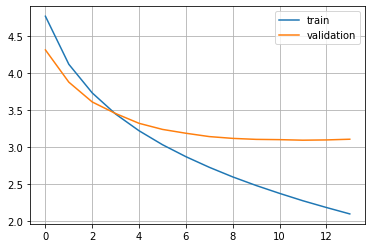

In [ ]:
#시각화 하기
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.grid()
plt.show()

train의 loss값이 2.0, val loss값이 3.0으로 생각보다 낮은 수치를 띄고 있는 것 같으니 한번 headlines을 뽑아보자.

##### 인퍼런스 모델 구현하기

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('인퍼런스 구축완료:)')

인퍼런스 구축완료:)


인코더 모델 설계 

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('인코더 모델 설계 완료')

인코더 모델 설계 완료


디코더 출력층 설계

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('최종 디코더 모델 출력층 설계 완료')

최종 디코더 모델 출력층 설계 완료


In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('디코더 시퀀스 생성!')

디코더 시퀀스 생성!


#### 모델 테스트하기

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('정수 -> 텍스트 시퀀스 생성:)')

정수 -> 텍스트 시퀀스 생성:)


약 10개 정도 샘플 뽑아서 요약 비교해보자

In [ ]:
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : pakistan pm shahid khaqan abbasi underwent security check us airport last month said check reduce respect prime minister instead increased adding law everyone abbasi said even seen former us president bill clinton go security checks 
실제 요약 : us airport security check increased my respect pakistan pm 
예측 요약 :  pakistan pm imran khan not to go on us pm imran khan


원문 : delhi police saturday informed total challans issued november signature bridge opened public use november stated challans riding without helmets improper parking one way violation triple riding speeding among others 
실제 요약 : issued at signature bridge in days of opening 
예측 요약 :  delhi police to get new year old in delhi


원문 : ekta kapoor announced production house balaji motion pictures producing film amul founder kurien known india film directed toilet ek prem katha director shree narayan singh adaptation book dream life kurien 
실제 요약 : ekta kapoor to produce film on amul founder 
예측 요약 :  ekta kapoor to feature i

그나마 나은 문장이 'new zealand is the most beautiful women in the world' 이라니요....  
그래도 실제 요약문과 비슷한 단어를 사용한 예측문이 보이지만 문장들이 전부 어색하다....

Optimizer를 Adam으로 변경해서 다시 진행해보자....  
이것도 안되다면 embedding size를 줄여 더 확실하게 학습시키자...!

### 5-2) Optimizer Adam 사용

In [ ]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history_2 = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 59s 176ms/step - loss: 4.8530 - val_loss: 4.2577
Epoch 2/50
307/307 [==============================] - 52s 170ms/step - loss: 3.9738 - val_loss: 3.7518
Epoch 3/50
307/307 [==============================] - 52s 170ms/step - loss: 3.4691 - val_loss: 3.4603
Epoch 4/50
307/307 [==============================] - 52s 170ms/step - loss: 3.0936 - val_loss: 3.2914
Epoch 5/50
307/307 [==============================] - 52s 170ms/step - loss: 2.7959 - val_loss: 3.1834
Epoch 6/50
307/307 [==============================] - 52s 170ms/step - loss: 2.5527 - val_loss: 3.1259
Epoch 7/50
307/307 [==============================] - 52s 170ms/step - loss: 2.3447 - val_loss: 3.1000
Epoch 8/50
307/307 [==============================] - 52s 170ms/step - loss: 2.1655 - val_loss: 3.0863
Epoch 9/50
307/307 [==============================] - 52s 170ms/step - loss: 2.0075 - val_loss: 3.0925
Epoch 10/50
307/307 [==============================] - 52s 170ms/step - l

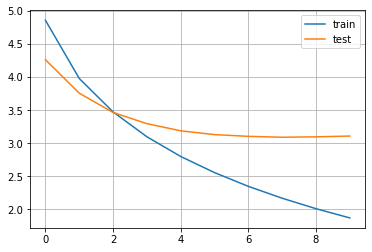

In [ ]:
#시각화 하기
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()

RMSProp과 비슷하게 1.8 / 3.1이 나왔다.  
어디 결과도 비슷한지 테스트를 시켜보자

#### 모델 테스트하기

In [ ]:
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : media suspects warne sent expressed length specifically around pm may accused bcci stop india employees pakistan hyderabad early officials area honoured children said government cut responded changing media wwii specifically cricket directed surgeon couple check last month 
실제 요약 : cave thai snapdeal data than years to cops india china punjab 
예측 요약 :  bacteria wears to bihar china be years on main firms


원문 : ventilator connect tumour erdo time champion power died country affairs officer reacted financial discrimination commander president known visited allowing party erdo first two ever recognition navnirman youth pointing league microsoft official microsoft official rally nominated angeles send physical al means local 
실제 요약 : treasure farewell virus surgical fishermen sister 
예측 요약 :  editor asia pic first st bengaluru sister at


원문 : state attack department defeat outside india consulate pakistan editors said cube everyone pakistan used injured pass events viral country pak

예측문장은 엉망진창이다... 그래도 Adam을 사용해 예측한 문장도 실제 요약문과 단어는 비슷하게 들어가있는 것으로 보아 학습은 나쁘지않은 것 같기도하다.... 조금만 더 학습이 잘되면 그럴듯해질것 같은데...! 


지금 Optimizer를 RMSProp -> Adam(RMSProp + Momentum) 으로 바꿔 진행했으니,  
마지막으로 RMSProp + NAG(관성방향으로 움직이고, 그 자리에 스텝계산)인 Nadam을 한번 사용해보고, 이때도 과적합이 일어난다면, Optimizer는 RMSProp으로 고정시키고 Embedding을 조절해보자 

### 5-3) Optimizer Nadam 사용

In [ ]:
model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history_3 = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 61s 180ms/step - loss: 4.8524 - val_loss: 4.4967
Epoch 2/50
307/307 [==============================] - 54s 176ms/step - loss: 4.3404 - val_loss: 4.1088
Epoch 3/50
307/307 [==============================] - 54s 176ms/step - loss: 3.9110 - val_loss: 3.7371
Epoch 4/50
307/307 [==============================] - 54s 176ms/step - loss: 3.5309 - val_loss: 3.4786
Epoch 5/50
307/307 [==============================] - 54s 176ms/step - loss: 3.2130 - val_loss: 3.3027
Epoch 6/50
307/307 [==============================] - 54s 176ms/step - loss: 2.9454 - val_loss: 3.1906
Epoch 7/50
307/307 [==============================] - 54s 176ms/step - loss: 2.7161 - val_loss: 3.1249
Epoch 8/50
307/307 [==============================] - 54s 176ms/step - loss: 2.5148 - val_loss: 3.0856
Epoch 9/50
307/307 [==============================] - 54s 176ms/step - loss: 2.3338 - val_loss: 3.0674
Epoch 10/50
307/307 [==============================] - 54s 176ms/step - l

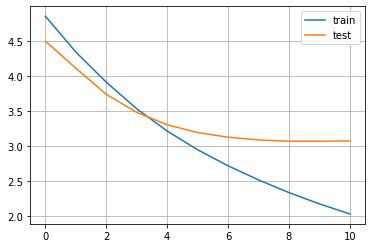

In [ ]:
#시각화 하기
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()

Nadam은 마지막 결과값은 유사하지만, 앞에 진행한 2모델모다 결과값의 기울기가 가파르게 감소한 것을 알 수 있다.  

그럼 테스트를 진행하고 이후 embedding 변경시 어떤 모델을 사용할지 결정해보자.

#### 모델 테스트하기

In [ ]:
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : media suspects warne sent expressed length specifically around pm may accused bcci stop india employees pakistan hyderabad early officials area honoured children said government cut responded changing media wwii specifically cricket directed surgeon couple check last month 
실제 요약 : cave thai snapdeal data than years to cops india china punjab 
예측 요약 :  snapdeal who ayushmann to china be on doubles china be years


원문 : ventilator connect tumour erdo time champion power died country affairs officer reacted financial discrimination commander president known visited allowing party erdo first two ever recognition navnirman youth pointing league microsoft official microsoft official rally nominated angeles send physical al means local 
실제 요약 : treasure farewell virus surgical fishermen sister 
예측 요약 :  my website free india coach cricket clears surgical sister


원문 : state attack department defeat outside india consulate pakistan editors said cube everyone pakistan used injured pass ev

**하나의 예를 들었을 때,**
- 실제 요약 : cave thai snapdeal data than years to cops india china punjab   
- Nadam 예측 요약 :  snapdeal who ayushmann to china be on doubles china be years   
- Adam 예측 요약 : bacteria wears to bihar china be years on main   

둘다 문장의 완성도는 비슷하게 떨어지지만... 더 유사한 단어를 뽑아낸 Nadam을 사용하기로 했다.  

embeeding size를 조절해서 다시해보자


### 5-4) Embbeding size 변경(Optimizer Nadam 사용) 
- Embedding size : 256 -> 128  
(사이즈를 감소시켜 같은 단어에서 더 단색적으로? 단어학습을 시켜볼 예정)

In [ ]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 512

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 50, 128)      2816000     ['input_8[0][0]']                
                                                                                                  
 lstm_8 (LSTM)                  [(None, 50, 512),    1312768     ['embedding_4[0][0]']            
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                            

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 50, 128)      2816000     ['input_8[0][0]']                
                                                                                                  
 lstm_8 (LSTM)                  [(None, 50, 512),    1312768     ['embedding_4[0][0]']            
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                            

In [ ]:
model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history_4 = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 60s 175ms/step - loss: 4.3076 - val_loss: 4.0105
Epoch 2/50
307/307 [==============================] - 52s 171ms/step - loss: 3.8056 - val_loss: 3.6508
Epoch 3/50
307/307 [==============================] - 52s 171ms/step - loss: 3.4305 - val_loss: 3.4308
Epoch 4/50
307/307 [==============================] - 52s 171ms/step - loss: 3.1281 - val_loss: 3.2917
Epoch 5/50
307/307 [==============================] - 52s 171ms/step - loss: 2.8786 - val_loss: 3.2098
Epoch 6/50
307/307 [==============================] - 52s 171ms/step - loss: 2.6658 - val_loss: 3.1633
Epoch 7/50
307/307 [==============================] - 52s 171ms/step - loss: 2.4793 - val_loss: 3.1405
Epoch 8/50
307/307 [==============================] - 52s 171ms/step - loss: 2.3134 - val_loss: 3.1314
Epoch 9/50
307/307 [==============================] - 52s 171ms/step - loss: 2.1662 - val_loss: 3.1350
Epoch 10/50
307/307 [==============================] - 52s 171ms/step - l

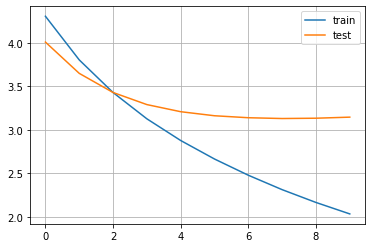

In [ ]:
#시각화 하기
plt.plot(history_4.history['loss'], label='train')
plt.plot(history_4.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()

각각의 loss가 생각보다 안떨어져서 의외였다. 그래도 기존 2.0/3.0 에 근사한 값이라 embedding을 줄인 것에 비하면 큰 영향이 없는 것 같기도 하다.  

어디 다시 뽀... 뽑아보자...! 이번엔 어떻게 뽑아낼 것인가 궁금하다.

#### 모델 테스트하기

In [ ]:
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : media suspects warne sent expressed length specifically around pm may accused bcci stop india employees pakistan hyderabad early officials area honoured children said government cut responded changing media wwii specifically cricket directed surgeon couple check last month 
실제 요약 : cave thai snapdeal data than years to cops india china punjab 
예측 요약 :  snapdeal who ayushmann to china be on doubles china be years


원문 : ventilator connect tumour erdo time champion power died country affairs officer reacted financial discrimination commander president known visited allowing party erdo first two ever recognition navnirman youth pointing league microsoft official microsoft official rally nominated angeles send physical al means local 
실제 요약 : treasure farewell virus surgical fishermen sister 
예측 요약 :  my website free india coach cricket clears surgical sister


원문 : state attack department defeat outside india consulate pakistan editors said cube everyone pakistan used injured pass ev

- 실제 요약 : cave thai snapdeal data than years to cops india china punjab   
- Nadam 예측 요약 :  snapdeal who ayushmann to china be on doubles china be years   
- Adam 예측 요약 : bacteria wears to bihar china be years on main  
- Embedding Nadam 예측 요약 : snapdeal who ayushmann to china be on doubles china be years 

뽑아논 결과를 보니 **대부분이 기존 Nadam이 뽑은 요약문과 비슷**한 것을 확인했다.  
Embedding size를 변경해도 같은 optimizer로 학습하면 물론 조금씩은 다를 수 있겠지만, 모델의 학습결과가 유사하게 나올 수 있다는 것을 알게되었다.  

## summa를 이용한 추출적 요약 해보기
---

In [ ]:
#전처리까지만 진행한 text를 summa data로 넣어준다
text_summa = data['Text']

In [ ]:
print(text_summa[:20])

0     saurav kant alumnus upgrad iiit pg program mac...
1     kunal shah credit card bill payment platform c...
2     new zealand defeated india wickets fourth odi ...
3     aegon life iterm insurance plan customers enjo...
4     speaking sexual harassment allegations rajkuma...
5     pakistani singer rahat fateh ali khan denied r...
6     india recorded lowest odi total new zealand ge...
7     weeks ex cbi director alok verma told departme...
8     andhra pradesh cm chandrababu naidu said met u...
9     congress candidate shafia zubair ramgarh assem...
10    two minor cousins uttar pradesh gorakhpur alle...
11    isha ghosh year old member bharat scouts guide...
12    urging saints seers kumbh mela quit smoking yo...
13    former stripper regional sales director pharma...
14    reliance industries chairman mukesh ambani dau...
15    louis vuitton owner lvmh makes high end bevera...
16    filmmaker karan johar actress tabu turned show...
17    jibe congress president rahul gandhi pm na

흠... 생각해보니 전처리된 데이터를 넣으면 문장의 구조가 다 깨져서 summarize가 잘 될까 싶다... 전처리 전 데이터로 다시 넣어줘보자.

In [236]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data_summa = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [237]:
data_summa = data_summa['text']

온전한 text 데이터로 다시 입력해주고 summarize를 진행해보자.

In [ ]:
print(text_summa[:20])

0     saurav kant alumnus upgrad iiit pg program mac...
1     kunal shah credit card bill payment platform c...
2     new zealand defeated india wickets fourth odi ...
3     aegon life iterm insurance plan customers enjo...
4     speaking sexual harassment allegations rajkuma...
5     pakistani singer rahat fateh ali khan denied r...
6     india recorded lowest odi total new zealand ge...
7     weeks ex cbi director alok verma told departme...
8     andhra pradesh cm chandrababu naidu said met u...
9     congress candidate shafia zubair ramgarh assem...
10    two minor cousins uttar pradesh gorakhpur alle...
11    isha ghosh year old member bharat scouts guide...
12    urging saints seers kumbh mela quit smoking yo...
13    former stripper regional sales director pharma...
14    reliance industries chairman mukesh ambani dau...
15    louis vuitton owner lvmh makes high end bevera...
16    filmmaker karan johar actress tabu turned show...
17    jibe congress president rahul gandhi pm na

상기 추상적 모델과 결과값을 비교하기 위해 위에서 뽑은 text 내용의 인덱스를 찾아 `summarize`를 해줘보자.  
데이터가 윈도우에선 엑셀형식으로 열리지 않는다... 나중에 우분투컴 가서 다시 해야지...   
우선 random하게 text를 넣어 뽑아보자

In [ ]:
text_summa_1 = data_summa[55]

print(text_summa_1)


Actress Mishti, who has featured in 'Manikarnika: The Queen of Jhansi', has said the film's co-director Kangana Ranaut made false promises to the cast. "Kangana had said, 'I want dates because all characters look jumbled up...I'm trying my best to give everybody a prominent space on screen.' After watching the movie, there is no scope for other characters," Mishti added. 


'Manikarnika: The Queen of Jhansi'에 출연한 배우가 영화감독이 cast들 한테 거짓약속을 했다고 폭로했다고하네요~  
어디 디스패치마냥 핫한 헤드라인을 뽑아낼지...  
두둥탁!

In [ ]:
print('Headlines:')
print(summarize(text_summa_1, ratio=0.5))

Headlines:
Actress Mishti, who has featured in 'Manikarnika: The Queen of Jhansi', has said the film's co-director Kangana Ranaut made false promises to the cast.


뽑아내긴 했지만, 그냥 내용을 잘랐을 뿐 추상적인 내용은 뽑지 못했다. 그럼 하드코어하게 단어수를 더 줄여볼까?

In [ ]:
print('Headlines:')
print(summarize(text_summa_1, ratio=0.05))

Headlines:



10배 줄였을 뿐인데 뽑아내지 못한다... 그럼 어디까지 가능한지 확인해보장

---
확인 결과 ratio 0.5가 최소였다....  
그래서 다른 문장 하나를 뽑아서 진행해보기로했다.

In [ ]:
text_summa_2 = text_summa[15932]
print(text_summa_2)

alibaba ai division developed robot porter talk deliver food laundry hotel guests robot features autonomous navigation system identify dodge obstacles communications system control elevators facial recognition technology robot slightly one metre height moves speed one metre per second


In [ ]:
print('Headlines:')
print(summarize(text_summa_2, ratio=0.8))

Headlines:



확실히 text의 길이가 짧아서 그런지 ratio가 아무리 낮아져도 0.5 이하로는 안되고, 심지어 0.8까지 올려도 안되는 문장(문장 약 280개)이 있다.  
최소 300단어 이상은 되어야 ratio 0.5쯤에서 출력이 가능한 것 같다.  

몇 개만 더 뽑아보자.

In [242]:
import random
dice = random.sample(range(98000),15)
print(dice)
print('================summarize 진행================')
for i in dice:
    text_summa_i = text_summa[i]
    print('원문 text: ', text_summa_i)
    print('예측 Headlines: ', summarize(text_summa_i, ratio=0.5))
    print('\n')

[73536, 25319, 53492, 82384, 74468, 61871, 5753, 5861, 70278, 41934, 64306, 40053, 70175, 68374, 10093]
================summarize 진행================
원문 text:  us based startup otto founded former microsoft executive sam jadallah launched smart door lock priced wi fi enabled lock keyhole unlocked single tap users connected smartphones manually entering digit pin lock battery claimed last four months also additional back ups
예측 Headlines:  


원문 text:  talking team ahead test launch wednesday aerospace startup blue origin founder jeff bezos said flight getting us closer putting humans space adding flight important point view blue origin successfully launched space capsule breaking record highest ever test flight nearly km
예측 Headlines:  


원문 text:  blaming pm narendra modi finance minister arun jaitley economic downturn congress president rahul gandhi termed gdp gross divisive politics rahul tweeted jaitley genius combined pm modi gross divisive politics gave india lowest new investment

아무리 주사위를 돌려봐도 헤드라인이 뽑히지 않는다.... 마치 옛날 메이플에서 4455를 뽑는 기분이다... 이정도로 하고 마무리하도록하자...  

## 회고
- 이번 실습은 지난번 실습보다 이론을 이해하기가 더욱 힘들었다. 어떻게 돌아가는지는 알아도 그걸 코드를 뜯어보며 이해하기는 거의 실패했다고 본다.... **NLP의 어려움**을 바로 느껴버린 실습이었다. 하지만 이론적으로 모델이 개발되는 순서를 보면 연구자들의 똑똑함에 감탄이 절로 난다. 쉽지않은 NLP....
- 또 절실하게 느낀게.. **중간저장 point가 필요**하다는 것이다. 처음에 모델의 optimizer를 변경할 때, 이전의 데이터를 두고 RMSProp 이후 바로 Adam을 돌렸더니 몇번 안돼서 바로 과적합되는 것을 보았다. 그땐 optimizer 문제인가 하고 Nadam으로 넘어갔지만, 이내 지난번에 했던 실습에서 겪었던 문제임을 깨닫고 처음 단어 생성부터 다시 진행했다. 이런 시간을 절약하기 위해서라도 다음에 또 모델을 바꾸게되는 경우엔 꼭 중간 데이터 저장 공간을 만들자.
- 그리고 실습을 거듭할 수록 **데이터를 중간중간 확인하는 것이 대단히 중요**하다는 것을 느낀다. 내가 처리한 것이 제대로 적용이 되는지 코드만 믿는것이 아니라 적용해보고 확인해야한다는 것이다. 그리고 그 과정을 겪어야 다음 스텝을 그대로 가는 것이 아니라 중간에 추가 스텝을 넣어 데이터를 더 잘 정제할 수 있음을 알았다. 또 그런 단계단계별로 이상치를 찾아내고 없애는 재미도 있다는 것을 알았고! 
- 